In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, HMC
from numpyro.infer.util import initialize_model
from numpyro import handlers

jax.config.update("jax_enable_x64", True)
print(jax.devices())

sys.path.append('../')

from cofilin.forward_model.config import Constants, FMConfig
from cofilin.forward_model.fmodel import FModel
from cofilin.forward_model.fourier import my_ifft
from cofilin.forward_model.bias import manage_params
from cofilin.forward_model.plot_utils import plot_cubes, compare_pow_spec

/home/pere/envs/jax311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[CudaDevice(id=0)]


In [2]:
N, Z_I, Z_F = 64, 99, 0
R = 3.4*4
L = R*N

cte = Constants(N, L, Z_I, Z_F)

lpt_method = "2LPT"
MND = 1e-2
N_TR = L**3 * MND

det_bias_model = "PowerLaw"
stoch_bias_model = "Poisson"

cweb = 'PhiWeb'
soft_cweb = True
cweb_sharpness = 10

fm_cfg = FMConfig(
    N,
    L,
    Z_I,
    Z_F,
    N_TR=N_TR,
    det_bias_model=det_bias_model,
    stoch_bias_model=stoch_bias_model,
    cweb=cweb,
    soft_cweb=soft_cweb,
    cweb_sharpness=cweb_sharpness
)
fmodel = FModel(fm_cfg)

[1.37600598 0.90375701 1.08309145 1.47636802]
[0.85991159 1.1432145  1.06248107 1.02004873]
[2.19525769 2.58635812 1.60231957 1.97480662]


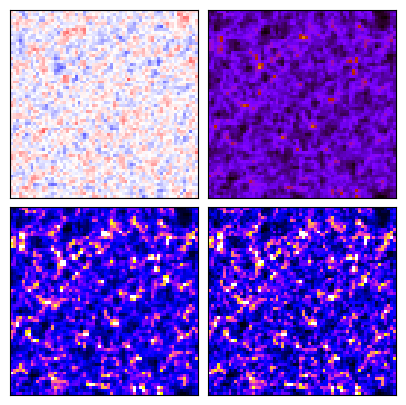

In [3]:
q_data = fmodel.input_arr(jax.random.PRNGKey(1))
delta_in_hat = fmodel.delta_in(q_data)
delta_in = my_ifft(delta_in_hat, cte.INV_L3)
delta_lpt = fmodel.delta_lpt(q_data)
cweb_arr = fmodel.cweb(delta_lpt)

get_n_tr_mean = fmodel.n_tr_mean()

key_params = jax.random.PRNGKey(0)
sks = jax.random.split(key_params, 3)

alpha = jax.random.normal(sks[0], (fm_cfg.n_regions,))*0.2 + 1
e_hp = jax.random.normal(sks[1], (fm_cfg.n_regions,))*0.1 + 1
rho_hp = jax.random.normal(sks[2], (fm_cfg.n_regions,))*0.5 + 2
# b = jax.random.normal(sks[1], (fm_cfg.n_regions,))*0.2 + 1
#beta = jax.random.normal(sks[2], (fm_cfg.n_regions,))*5 + 15

params = {"alpha": alpha, "e_hp": e_hp, "rho_hp": rho_hp}
params = manage_params(params)
n_tr_mean = get_n_tr_mean(delta_lpt, params, cweb_arr)

key_sample = jax.random.PRNGKey(1)
n_tr_data = fmodel.sample_n_tr(n_tr_mean, key_sample, params=params, cweb=cweb_arr)

lim_dev = 10 * jnp.std(delta_lpt)
vlim_dev = (-1, lim_dev)

lim_n_tr = jnp.mean(n_tr_data) + 3 * jnp.std(n_tr_data)
vlim_n_tr = (0, lim_n_tr)

fig, ax = plot_cubes(
    [delta_in, delta_lpt, n_tr_mean, n_tr_data],
    cmap=["seismic_r", "gnuplot"]+["gnuplot2"]*2,
    vlim=[0.1, vlim_dev]+[vlim_n_tr]*2,
    width=1, axis=2, idx=N//2
)

print(params['alpha'])
print(params['e_hp'])
print(params['rho_hp'])

In [4]:
model = fmodel.build_model()

alpha_fixed = jnp.array([1.0] * 4)
e_hp_fixed = jnp.array([1.0] * 4)
rho_hp_fixed = jnp.array([2.0] * 4)

# alpha_fixed = alpha
# e_hp_fixed = e_hp
# rho_hp_fixed = rho_hp


# b_fixed = jnp.array([1.]*4)

conditioned_model = handlers.condition(
    model, data={"alpha": alpha_fixed}  # the model that still has sample("alpha", …)
)


#   "e_hp": e_hp_fixed,
#   "rho_hp": rho_hp_fixed},
# )
def tempered_conditioned_model(data, T=1):
    """Posterior ∝  [prior * likelihood]^(1/T)"""
    with handlers.scale(scale=1.0 / T):
        conditioned_model(data)


# def tempered_model(data, T=1):
#     """Posterior ∝  [prior * likelihood]^(1/T)"""
#     with handlers.scale(scale=1.0 / T):
#         model(data)

### NUTS Unconditioned

In [10]:
from numpyro.infer import init_to_value

# key_q_init = jax.random.PRNGKey(11)
# q_init = fmodel.input_arr(key_q_init) * 1
# init_params = {"q": q_init}
# init_strategy = init_to_value(values=init_params)

max_tree_depth = 8
adapt_mass_matrix = True
dense_mass = False

key = jax.random.PRNGKey(1)
kernel = NUTS(
    model,
    dense_mass=dense_mass,
    adapt_mass_matrix=adapt_mass_matrix,
    max_tree_depth=max_tree_depth,
    adapt_step_size=True,
    #init_strategy=init_to_value(values=init_params),
)
mcmc = MCMC(kernel, num_warmup=50, num_samples=2, thinning=1, progress_bar=True)
mcmc.run(key, data=n_tr_data)
posterior = mcmc.get_samples()

sample: 100%|██████████| 52/52 [00:23<00:00,  2.18it/s, 255 steps of size 6.37e-04. acc. prob=0.92]


In [20]:
prev_state = mcmc.last_state
# Unconstrained latent values
z0 = prev_state.z
# Tuned HMC hyper-parameters
eps0  = prev_state.adapt_state.step_size
invM0 = prev_state.adapt_state.inverse_mass_matrix
# --- 2. Build a new fixed-kernel that reuses them --------------------------
kernel2 = NUTS(
    tempered_conditioned_model,
    step_size=eps0,
    inverse_mass_matrix=invM0,
    dense_mass=False,
    adapt_step_size=True,     # no further step-size adaptation
    adapt_mass_matrix=True,   # keep the previous mass matrix
    max_tree_depth=8,
)
mcmc2 = MCMC(kernel2, num_warmup=1000, num_samples=1, thinning=1, progress_bar=True)
# --- 3. Run from the last position z0 ------------------------------------
rng2 = jax.random.PRNGKey(4)
mcmc2.run(rng2, init_params=z0, data=n_tr_data, T=1.0)
posterior2 = mcmc2.get_samples()

sample: 100%|██████████| 1001/1001 [07:45<00:00,  2.15it/s, 255 steps of size 2.18e-03. acc. prob=0.67]


(<Figure size 1500x500 with 3 Axes>,
 array([<Axes: xlabel='$k$ [$h$/Mpc]'>, <Axes: xlabel='$k$ [$h$/Mpc]'>,
        <Axes: xlabel='$k$ [$h$/Mpc]'>], dtype=object))

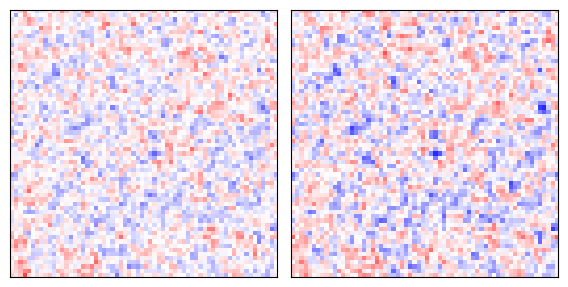

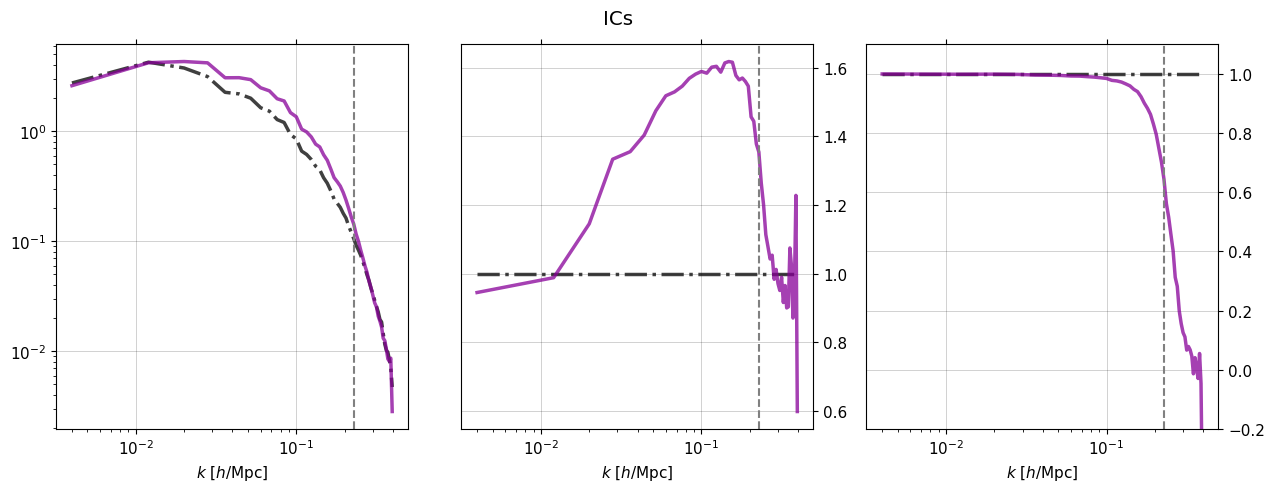

In [27]:
delta_in_fit_hat = fmodel.delta_in(posterior['q'][0])
delta_in_fit = my_ifft(delta_in_fit_hat, cte.INV_L3)

plot_cubes([delta_in, delta_in_fit], cmap='seismic_r', vlim=1e-1)
compare_pow_spec([delta_in, delta_in_fit], L=L, xlog=True, no_labels=['Reference', 'Fit'], title='ICs')

In [29]:
q_init = mcmc.get_samples()["q"][-1]
init_vals = {"q": q_init, "alpha": alpha_fixed, "e_hp": e_hp_fixed, "rho_hp": rho_hp_fixed}
from numpyro.infer import init_to_value
init_strat = init_to_value(values=init_vals)

kernel2 = NUTS(
    model,
    dense_mass=False,
    adapt_mass_matrix=True,
    adapt_step_size=True,
    max_tree_depth=9,
    init_strategy=init_strat
)
mcmc2 = MCMC(kernel2, num_warmup=1000, num_samples=100, thinning=1)
mcmc2.run(jax.random.PRNGKey(2), data=n_tr_data)
posterior = mcmc2.get_samples()

  0%|          | 0/1100 [00:00<?, ?it/s]

sample: 100%|██████████| 1100/1100 [17:48<00:00,  1.03it/s, 511 steps of size 1.51e-03. acc. prob=0.84]


(<Figure size 1500x500 with 3 Axes>,
 array([<Axes: xlabel='$k$ [$h$/Mpc]'>, <Axes: xlabel='$k$ [$h$/Mpc]'>,
        <Axes: xlabel='$k$ [$h$/Mpc]'>], dtype=object))

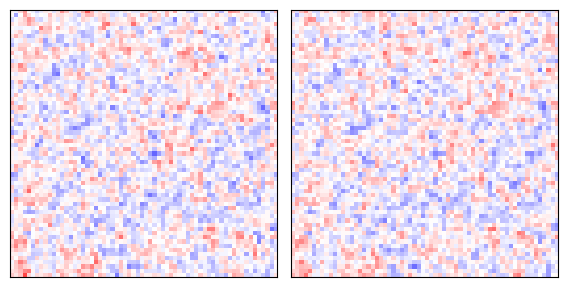

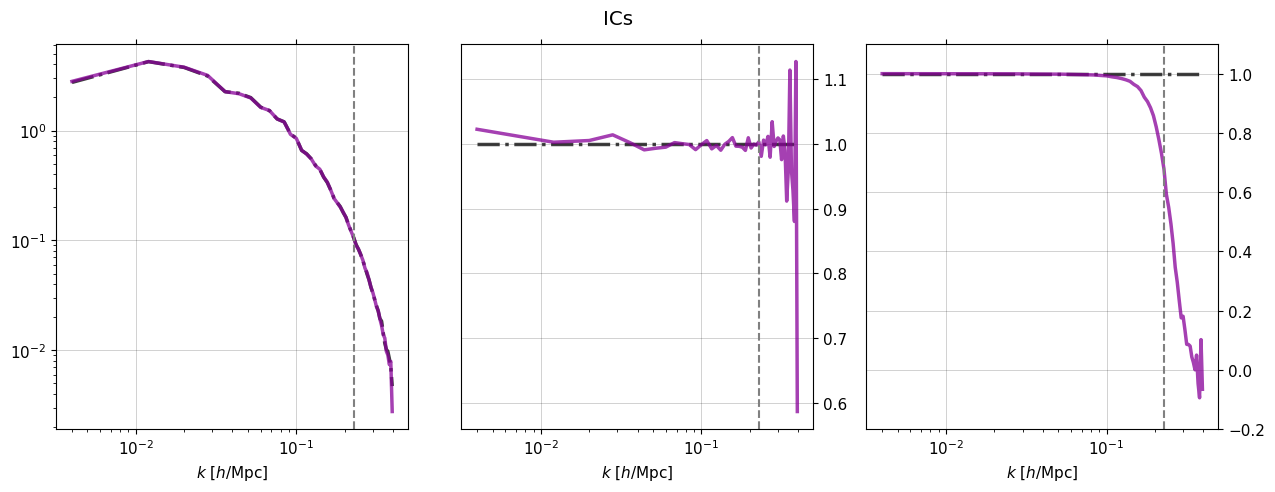

In [35]:
delta_in_fit_hat = fmodel.delta_in(posterior['q'][-1])
delta_in_fit = my_ifft(delta_in_fit_hat, cte.INV_L3)

plot_cubes([delta_in, delta_in_fit], cmap='seismic_r', vlim=1e-1)
compare_pow_spec([delta_in, delta_in_fit], L=L, xlog=True, no_labels=['Reference', 'Fit'], title='ICs')

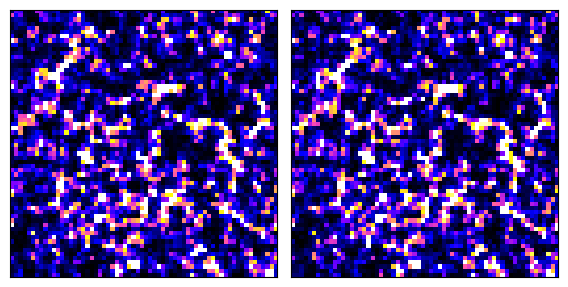

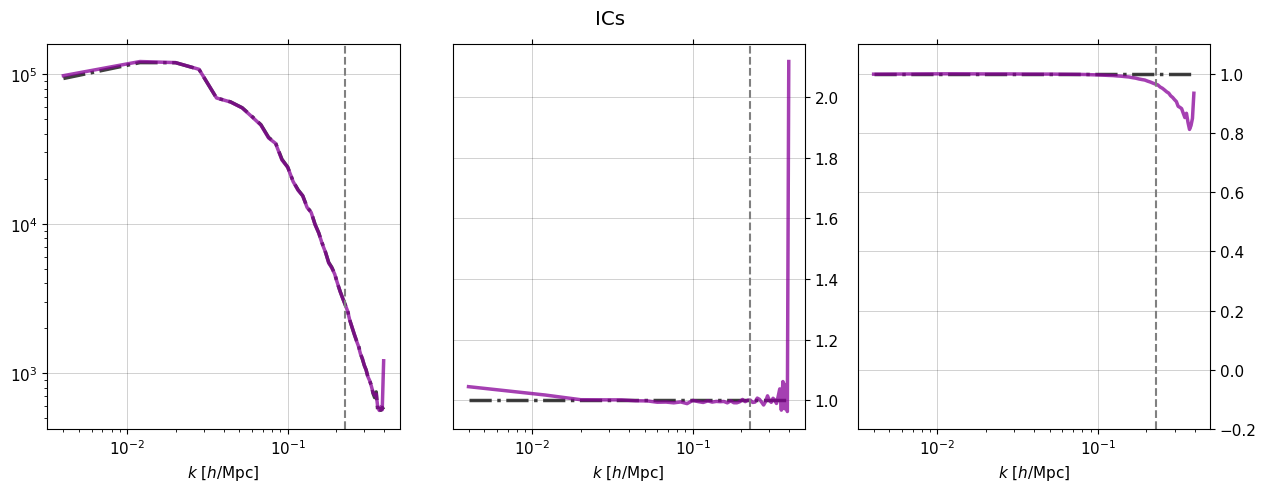

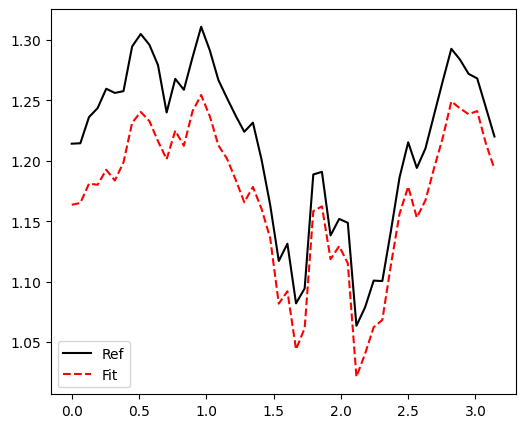

In [ ]:
q = posterior['q'][-1]
delta_lpt = fmodel.delta_lpt(q)
cweb_arr = fmodel.cweb(delta_lpt)
get_n_tr_mean = fmodel.n_tr_mean()
params_fit = {}
for key in params.keys():
    params_fit[key] = posterior[key][-1]

n_tr_mean = get_n_tr_mean(delta_lpt, params, cweb_arr)
key_sample = jax.random.PRNGKey(2)
n_tr_fit = fmodel.sample_n_tr(n_tr_mean, key_sample, params=params, cweb=cweb_arr)

delta_n_tr_data = (N**3 / n_tr_data.sum()) * n_tr_data - 1
delta_n_tr_fit = (N**3 / n_tr_fit.sum()) * n_tr_fit - 1

plot_cubes([n_tr_data, n_tr_fit], cmap='gnuplot2', vlim=(0, 80))
compare_pow_spec([delta_n_tr_data, delta_n_tr_fit], L=L, xlog=True, no_labels=['Reference', 'Fit'], title='ICs')


from cofilin.forward_model.stats import get_reduced_bispectrum
fs, rat = 5, 1.2
fig, ax = plt.subplots(1, 1, figsize=(fs*rat, fs))

thetas = jnp.linspace(0, jnp.pi, 50)
k1, k2 = 0.1, 0.2

bk_data = get_reduced_bispectrum(delta_n_tr_data, L, k1, k2, thetas)
bk_fit = get_reduced_bispectrum(delta_n_tr_fit, L, k1, k2, thetas)

ax.plot(thetas, bk_data, ls='-', c='k', label='Ref')
ax.plot(thetas, bk_fit, ls='--', c='r', label='Fit')

ax.legend()


In [39]:
params

{'alpha': Array([1.37600598, 0.90375701, 1.08309145, 1.47636802], dtype=float64),
 'e_hp': Array([0.85991159, 1.1432145 , 1.06248107, 1.02004873], dtype=float64),
 'rho_hp': Array([2.19525769, 2.58635812, 1.60231957, 1.97480662], dtype=float64)}

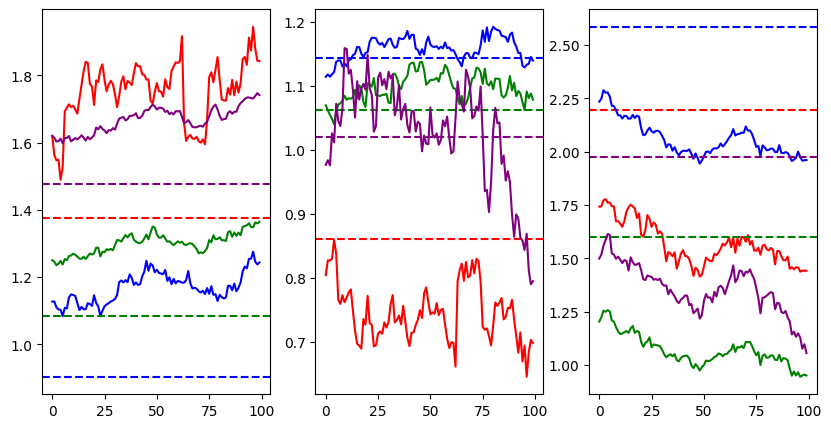

In [34]:
fs, rat = 5, 2
fig, axs = plt.subplots(1, 3, figsize=(fs*rat, fs))

cs = ['r', 'b', 'g', 'purple']
for i in range(4):
    axs[0].plot(posterior['alpha'][:,i], c=cs[i])
    axs[0].axhline(params['alpha'][i], c=cs[i], ls='--')

    axs[1].plot(posterior['e_hp'][:,i], c=cs[i])
    axs[1].axhline(params['e_hp'][i], c=cs[i], ls='--')

    axs[2].plot(posterior['rho_hp'][:,i], c=cs[i])
    axs[2].axhline(params['rho_hp'][i], c=cs[i], ls='--')

    # axs[1].plot(posterior['b'][:,i]/posterior['b'][:,3], c=cs[i])
    # axs[1].axhline(params['b'][i]/params['b'][3], c=cs[i], ls='--')

In [ ]:
from numpyro.infer import init_to_value

key_q_init = jax.random.PRNGKey(11)
q_init = fmodel.input_arr(key_q_init) * 1
init_params = {"q": q_init}
init_strategy = init_to_value(values=init_params)

step_size = 1e-2  # choose by trial – no adaptation will adjust it
n_steps = 100
trajectory_length = step_size * n_steps  # path length = step_size × num_steps
invM_diag = jnp.ones((N**3,)) * 0.5  # variance = 2

kernel = HMC(
    tempered_conditioned_model,
    step_size=step_size,
    trajectory_length=trajectory_length,
    adapt_step_size=False,
    adapt_mass_matrix=True,
    dense_mass=False,
    find_heuristic_step_size=False,
    inverse_mass_matrix=invM_diag,
    init_strategy=init_to_value(values=init_params),
)

mcmc = MCMC(kernel, num_warmup=100, num_samples=1, thinning=1, progress_bar=True)

rng_key = jax.random.PRNGKey(0)
mcmc.run(rng_key, data=n_tr_data, T=1e1)  # temperature 5, no adaptation
posterior = mcmc.get_samples()

In [1]:
import pickle

path = "/home/pere/code/cofilin-repo/z_recs/phiweb_pl/N64_R14_RSD_SQ1/TEST1/CH00/sample_cfg.json"
with open(path, "rb") as f:
    cfg = pickle.load(f)

{('alpha', 'q'): Array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)}